In [ ]:
!pip install crypten

### Creating Encrypted Tensors
CrypTen provides a ```crypten.cryptensor``` factory function, similar to ```torch.tensor```, to make creating ```CrypTensors``` easy.

Let's begin by creating a ```torch``` tensor and encrypting it using ```crypten.cryptensor```. To decrypt a ```CrypTensor```, use ```get_plain_text()``` to return the original tensor.  (```CrypTensors``` can also be created directly from a list or an array.)


In [ ]:
# Create torch tensor
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]])

# Encrypt x
x_enc = crypten.cryptensor(x)

crypten.print(x_enc)
# Decrypt x
x_dec = x_enc.get_plain_text()
crypten.print(x_dec)


# Create python list
y = [4.0, 5.0, 6.0]

# Encrypt y
y_enc = crypten.cryptensor(y)
crypten.print(y_enc)
# Decrypt y
y_dec = y_enc.get_plain_text(y_enc)
crypten.print(y_dec)

MPCTensor(
	_tensor=tensor([[ 65536, 131072],
        [196608, 262144]])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)
tensor([[1., 2.],
        [3., 4.]])
MPCTensor(
	_tensor=tensor([262144, 327680, 393216])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)
tensor([4., 5., 6.])


## Operations on Encrypted Tensors
Now let's look at what we can do with our ```CrypTensors```.

#### Arithmetic Operations
We can carry out regular arithmetic operations between ```CrypTensors```, as well as between ```CrypTensors``` and plaintext tensors. Note that these operations never reveal any information about encrypted tensors (internally or externally) and return an encrypted tensor output.

In [ ]:
#Arithmetic operations between CrypTensors and plaintext tensors
x_enc = crypten.cryptensor([1.0, 2.0, 3.0])

y = 2.0
y_enc = crypten.cryptensor(2.0)


# Addition
z_enc1 = x_enc + y     # Public
z_enc2 = x_enc + y_enc  # Private
crypten.print("\nPublic  addition:", z_enc1.get_plain_text())
crypten.print("Private addition:", z_enc2.get_plain_text())


# Subtraction
z_enc1 = x_enc - y     # Public
z_enc2 = x_enc - y_enc  # Private
crypten.print("\nPublic  subtraction:", z_enc1.get_plain_text())
print("Private subtraction:", z_enc2.get_plain_text())

# Multiplication
z_enc1 = x_enc * y     # Public
z_enc2 = x_enc * y_enc  # Private
print("\nPublic  multiplication:", z_enc1.get_plain_text())
print("Private multiplication:", z_enc2.get_plain_text())

# Division
z_enc1 = x_enc / y      # Public
z_enc2 = x_enc / y_enc  # Private
print("\nPublic  division:", z_enc1.get_plain_text())
print("Private division:", z_enc2.get_plain_text())


Public  addition: tensor([3., 4., 5.])
Private addition: tensor([3., 4., 5.])

Public  subtraction: tensor([-1.,  0.,  1.])
Private subtraction: tensor([-1.,  0.,  1.])

Public  multiplication: tensor([2., 4., 6.])
Private multiplication: tensor([2., 4., 6.])

Public  division: tensor([0.5000, 1.0000, 1.5000])
Private division: tensor([0.5000, 1.0000, 1.5000])


# Training custom pytorch model using Crypten

In [ ]:
import crypten
import torch
import torchvision
import torchvision.transforms as transforms

# Load the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define the model architecture
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Encrypt the model
# set device to GPU if available, otherwise use CPU
device = torch.device("cpu")

# initialize Crypten to use the same device
crypten.init(device=device)

dummy_input = torch.randn(1, 3, 32, 32).to(device)

# Define the loss function and optimizer
criterion = crypten.nn.CrossEntropyLoss().to(device)
optimizer = crypten.optim.SGD

# Train the model on encrypted data
model = Net().to(device)
encrypted_model = crypten.nn.from_pytorch(model, dummy_input.float()).to(device)
encrypted_model.encrypt()
optimizer = optimizer(encrypted_model.parameters(), lr=0.001, momentum=0.9)


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



/usr/local/lib/python3.9/dist-packages/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)


In [ ]:
from tqdm import tqdm
import torch.nn.functional as F

epochs =3
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(tqdm(trainloader)):
        encrypted_inputs = crypten.cryptensor(images.to(device))  # move input tensor to GPU
        encrypted_labels = crypten.cryptensor(F.one_hot(labels.to(device), num_classes=10).to(device))
        optimizer.zero_grad()
        encrypted_outputs = encrypted_model(encrypted_inputs)
        encrypted_loss = criterion(encrypted_outputs, encrypted_labels)
        encrypted_loss.backward()
        optimizer.step()

        running_loss += encrypted_loss.get_plain_text().item()
        _, predicted = encrypted_outputs.get_plain_text().max(1)
        total += encrypted_labels.get_plain_text().size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


100%|██████████| 782/782 [37:54<00:00,  2.91s/it]


Epoch 1/3, Loss: 2.3120, Accuracy: 10.60%


100%|██████████| 782/782 [36:55<00:00,  2.83s/it]


Epoch 2/3, Loss: 2.3109, Accuracy: 11.73%


100%|██████████| 782/782 [36:47<00:00,  2.82s/it]

Epoch 3/3, Loss: 2.3107, Accuracy: 12.49%


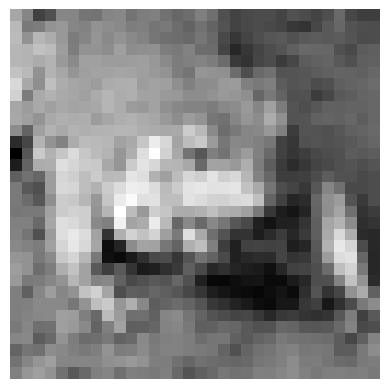

Label for image is: 6
Predicted label is: 6


In [ ]:
import matplotlib.pyplot as plt
image = testset[5][0][1]

# Plot the image
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

# Print the label of the image
print("Label for image is:", testset[5][1])
prediction = encrypted_model(crypten.cryptensor(testset[5][0].reshape([1,3,32,32]))).get_plain_text().argmax()
print('Predicted label is:', int(prediction))

In [ ]:
correct = 0
for image,label in tqdm(testset):
  prediction = encrypted_model(crypten.cryptensor(image.reshape([1,3,32,32]))).get_plain_text().argmax()
  if prediction == label:
    correct = correct+1

100%|██████████| 10000/10000 [24:11<00:00,  6.89it/s]


In [ ]:
print('Average test Accuracy :',float(correct / 10000))

Average test Accuracy : 0.1345


# Training Classifier model using Crypten

In [ ]:
import sys
import torch
import torchvision
import matplotlib.pyplot as plt


#python 3.7 is required
#assert sys.version_info[0] == 3 and sys.version_info[1] == 7, "python 3.7 is required"

import crypten
crypten.init()

%matplotlib inline

/usr/local/lib/python3.9/dist-packages/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)


In [ ]:
digits = torchvision.datasets.MNIST(root = '/temp/data', train = True, transform=torchvision.transforms.ToTensor(), download=True)

digits_test = torchvision.datasets.MNIST(root = '/temp/data', train = False, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 188703454.67it/s]

Extracting /temp/data/MNIST/raw/train-images-idx3-ubyte.gz to /temp/data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25268188.12it/s]


Extracting /temp/data/MNIST/raw/train-labels-idx1-ubyte.gz to /temp/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 83204699.25it/s]

Extracting /temp/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /temp/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17209149.75it/s]

Extracting /temp/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /temp/data/MNIST/raw



Ploting an imgae from MNIST data set and associate label

label for image is  5


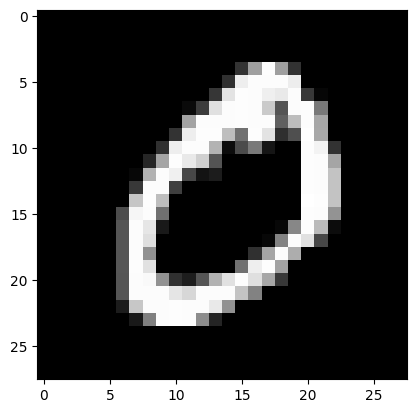

In [ ]:
plt.imshow(digits[1][0][0], cmap='gray', interpolation='none')
print("label for image is ", digits[0][1])

In [ ]:
digits[1][1]

0

Preprocessing data for training

In [ ]:
def take_samples(digits, n_samples=1000):
    """Returns images and labels based on sample size"""
    images, labels = [], []

    for i, digit in enumerate(digits):
        if i == n_samples:
            break
        # Prepare samples
        image, label = digit
        images.append(image)
        temp = torch.nn.functional.one_hot(torch.tensor(label),10)
        labels.append(temp)
    images = torch.cat(images)
    labels = torch.stack(labels)
    return images, labels

In [ ]:
# Prepare training samples using take_samples()
images, labels = take_samples(digits, 1000)

In [ ]:
# Prepare testing samples using take_samples()
images_test, labels_test = take_samples(digits, 100)

label for image is  tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])


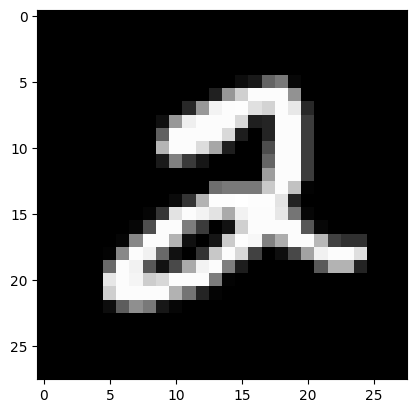

In [ ]:
plt.imshow(images[5], cmap='gray', interpolation='none')
print("label for image is ", labels[5])

Encrypting image and labels for training

In [ ]:
# Please encrypt the images and labels using crypten.cryptensor() function
images_enc = crypten.cryptensor(images)
labels_enc = crypten.cryptensor(labels)

encrypted image is stored in MPCTensor: encrypted using the secure MPC protocol. In order to support the mathematical

In [ ]:
images_enc[0]

MPCTensor(
	_tensor=tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
     

Plotting decrypted pixels of encrypted image

label for image is  tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


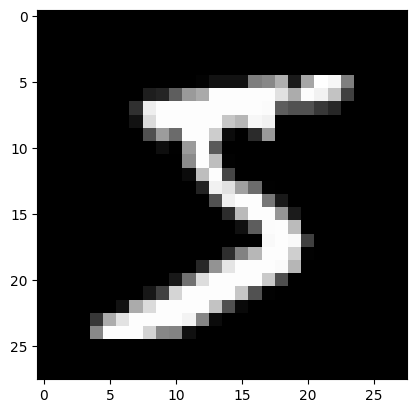

In [ ]:
plt.imshow(images_enc.get_plain_text()[0], cmap='gray', interpolation='none')
print("label for image is ", labels_enc.get_plain_text()[0])

In [ ]:
# prepare encrypt testing samples
images_test_enc = crypten.cryptensor(images_test)
labels_test_enc = crypten.cryptensor(labels_test)

Creating a simple Logistic regression model using crypten provided nn module


The model takes in a flattened image tensor of size 784, and passes it through three fully connected layers with 256, 128, and 10 output units respectively. This allows the model to transform the input image into a 2D tensor of logits representing the probability distribution over the 10 possible digit classes

In [ ]:
class LogisticRegression(crypten.nn.Module):

    def __init__(self):
        super().__init__()
        # images are 28x28 pixels
        self.linear1 = crypten.nn.Linear(28 * 28, 256)
        self.linear2= crypten.nn.Linear(256,128)
        self.linear3= crypten.nn.Linear(128,10)


    def forward(self, x):
        x = x.view(-1,784)
        x = self.linear1(x)
        x = self.linear2(x)
        return self.linear3(x)


Encrypting the crypten model

In [ ]:
model = LogisticRegression().encrypt()

Tesing the model functionality

In [ ]:
model(images_enc.reshape([-1,28*28]))

MPCTensor(
	_tensor=tensor([[ -9551,   3334, -12409,  ..., -10518,  -1740, -13630],
        [ -7734,   3826,  -4487,  ..., -12209,     72,  -6832],
        [ -3774,   5319,  -1444,  ...,  -7907,   6479,  -5489],
        ...,
        [ -1009,   7983,  -2998,  ..., -12763,   -197,  -6966],
        [ -5696,   8636,  -7547,  ...,  -9947,  -1567,  -2560],
        [ -5468,   7714,  -2079,  ...,  -6587,   3345,  -5343]])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)

Training the model

In [ ]:
def train_model(model, X, y, epochs=60, learning_rate=0.03):
    criterion = crypten.nn.CrossEntropyLoss() #-sum(p * log(q))

    for epoch in range(epochs):
        model.zero_grad()
        # calculate the loss
        output = model(X)
        loss = criterion(output, y)
        print(f"epoch {epoch} loss: {loss.get_plain_text()}")
        loss.backward()
        model.update_parameters(learning_rate)
    return model

In [ ]:
model = train_model(model, images_enc.reshape(-1,784), labels_enc)

epoch 0 loss: 2.315460205078125
epoch 1 loss: 2.3122711181640625
epoch 2 loss: 2.3091888427734375
epoch 3 loss: 2.3060150146484375
epoch 4 loss: 2.3029632568359375
epoch 5 loss: 2.29986572265625
epoch 6 loss: 2.29681396484375
epoch 7 loss: 2.293670654296875
epoch 8 loss: 2.290679931640625
epoch 9 loss: 2.2875823974609375
epoch 10 loss: 2.28460693359375
epoch 11 loss: 2.281494140625
epoch 12 loss: 2.27850341796875
epoch 13 loss: 2.275604248046875
epoch 14 loss: 2.2725067138671875
epoch 15 loss: 2.269561767578125
epoch 16 loss: 2.2666168212890625
epoch 17 loss: 2.2635955810546875
epoch 18 loss: 2.260772705078125
epoch 19 loss: 2.2577667236328125
epoch 20 loss: 2.2547149658203125
epoch 21 loss: 2.2518157958984375
epoch 22 loss: 2.2489013671875
epoch 23 loss: 2.245849609375
epoch 24 loss: 2.242919921875
epoch 25 loss: 2.239776611328125
epoch 26 loss: 2.236785888671875
epoch 27 loss: 2.2337646484375
epoch 28 loss: 2.230621337890625
epoch 29 loss: 2.2275848388671875
epoch 30 loss: 2.22438049

Make predictions on a test data image which is not used for training

In [ ]:
prediction = model(crypten.cryptensor(images[3]).reshape(-1,28*28))
prediction.get_plain_text().argmax()

tensor(1)

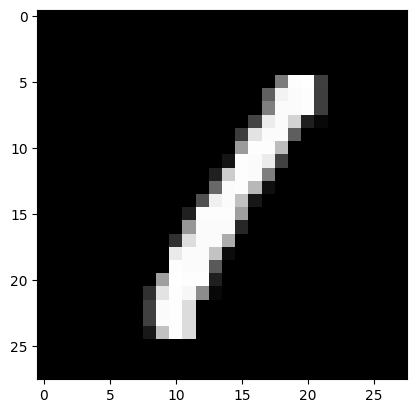

In [ ]:
plt.imshow(images[3], cmap='gray', interpolation='none')

Computing total average accuracy on entire test dataset

In [ ]:
def avg_test_accuracy(model, X, y):
    # calculate predicted labels and then calculate the accuracy with the groundtruth ones.
    correct = 0
    outputs = model(X.reshape(-1, 28*28))
    predicted = outputs.get_plain_text()
    labels = y.get_plain_text()
    for i,j in zip(predicted,labels):
      if i.argmax() == j.argmax():
        correct = correct+1
    print('Average test Accuracy :',float(correct / y.shape[0]))

In [ ]:
avg_test_accuracy(model, images_test_enc.reshape([-1,28*28]), labels_test_enc)

Average test Accuracy : 0.69
